### Importing libraries

In [87]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
from math import sqrt
%matplotlib inline

### Dataset

In [3]:
data_nights = pd.read_csv('/Users/sekou/Documents/GitHub/touristcast/datasets/nights_2010-2017.csv', index_col='date')
data_nights = data_nights.drop('Unnamed: 0', axis=1)
data_nights
nights_PAC = data_nights[['nights_PAC']]
nights_PAC.head()

,nights_PAC
date,
2010-01-01,956.88
2010-02-01,1114.93
2010-03-01,1327.84
2010-04-01,1727.31
2010-05-01,2066.52


In [4]:
data_temp = pd.read_csv('/Users/sekou/Documents/GitHub/touristcast/datasets/avgtemp_2010-2017.csv', index_col='date')
data_temp = data_temp.drop('Unnamed: 0', axis=1)
data_temp
avgtemp_PAC = data_temp[['avgtemp_PAC']]
avgtemp_PAC.head()

,avgtemp_PAC
date,
2010-01-01,5.0
2010-02-01,7.0
2010-03-01,9.0
2010-04-01,14.0
2010-05-01,17.0


In [5]:
data_daysoff = pd.read_csv('/Users/sekou/Documents/GitHub/touristcast/datasets/daysoff_2010-2017.csv', index_col='date')
data_daysoff = data_daysoff.drop('Unnamed: 0', axis=1)
data_daysoff.head()

,daysoff
date,
2010-01-01,11
2010-02-01,9
2010-03-01,9
2010-04-01,10
2010-05-01,12


In [6]:
data_gdp = pd.read_csv('/Users/sekou/Documents/GitHub/touristcast/datasets/regionalGDP_2010-2015.csv', index_col='date')
data_gdp = data_gdp.drop('Unnamed: 0', axis=1)
data_gdp
gdp_PAC = data_gdp[['gdp_PAC']]
gdp_PAC.head()

,gdp_PAC
date,
2010-01-01,143112.575866
2010-02-01,143112.575866
2010-03-01,143112.575866
2010-04-01,143112.575866
2010-05-01,143112.575866


In [7]:
data_PAC = pd.concat([nights_PAC, avgtemp_PAC, data_daysoff, gdp_PAC], axis=1, sort=False)
data_PAC.index = pd.to_datetime(data_PAC.index)
data_PAC_train = data_PAC.dropna(axis=0, how='any')
print(data_PAC_train.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2010-01-01 to 2015-12-01
Data columns (total 4 columns):
nights_PAC     72 non-null float64
avgtemp_PAC    72 non-null float64
daysoff        72 non-null int64
gdp_PAC        72 non-null float64
dtypes: float64(3), int64(1)
memory usage: 2.8 KB
None


### Stationarity check

In [8]:
from statsmodels.tsa.stattools import adfuller

for column in data_PAC_train.columns:
    result = adfuller(data_PAC_train[column])
    print(f'Stationarity test for variable {column}')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] < 0.05:
        print('STATIONARY')
        print(f'{column}')
        print('-------')
    else:
        print('NON-STATIONARY')
        print(f'{column}')
        print('-------')

Stationarity test for variable nights_PAC
ADF Statistic: -2.225807
p-value: 0.197013
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594
NON-STATIONARY
nights_PAC
-------
Stationarity test for variable avgtemp_PAC
ADF Statistic: -0.294483
p-value: 0.926282
Critical Values:
	1%: -3.544
	5%: -2.911
	10%: -2.593
NON-STATIONARY
avgtemp_PAC
-------
Stationarity test for variable daysoff
ADF Statistic: -3.149484
p-value: 0.023101
Critical Values:
	1%: -3.544
	5%: -2.911
	10%: -2.593
STATIONARY
daysoff
-------
Stationarity test for variable gdp_PAC
ADF Statistic: -1.015064
p-value: 0.747730
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
NON-STATIONARY
gdp_PAC
-------


Result:
- Nights, AvgTemp, GDP are all non-stationary
- Daysoff is stationary (also doesn't require forecasting as we already have the answers)

#### Figure out which series' seasonality is additive or multiplicative

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# ----- Additive Model below -----

add_data = seasonal_decompose(data_PAC_train, model='additive')  

add_trend = add_data.trend.dropna()
add_seasonal = add_data.seasonal.dropna()
add_residual = add_data.resid.dropna()

# stationarity_test(add_residual)

# ----- Multiplicative Model below -----

mult_data = seasonal_decompose(data_PAC_train, model='multiplicative')  

mult_trend = mult_data.trend.dropna()
mult_seasonal = mult_data.seasonal.dropna()
mult_residual = mult_data.resid.dropna()

# stationarity_test(mult_residual)

In [10]:
from statsmodels.tsa.stattools import acf

add_acfs = add_residual.apply(acf, axis=0).apply(np.square, axis=0).apply(np.sum)

mult_acfs = mult_residual.apply(acf, axis=0).apply(np.square, axis=0).apply(np.sum)

additive = add_acfs < mult_acfs
add_cols = additive.index[additive].tolist()
mult_cols = additive.index[~additive].tolist()
print(add_cols)
print(mult_cols)

['daysoff']
['nights_PAC', 'avgtemp_PAC', 'gdp_PAC']


> Nights, AvgTemp, and GDP are all multiplicative series

<Figure size 432x288 with 0 Axes>

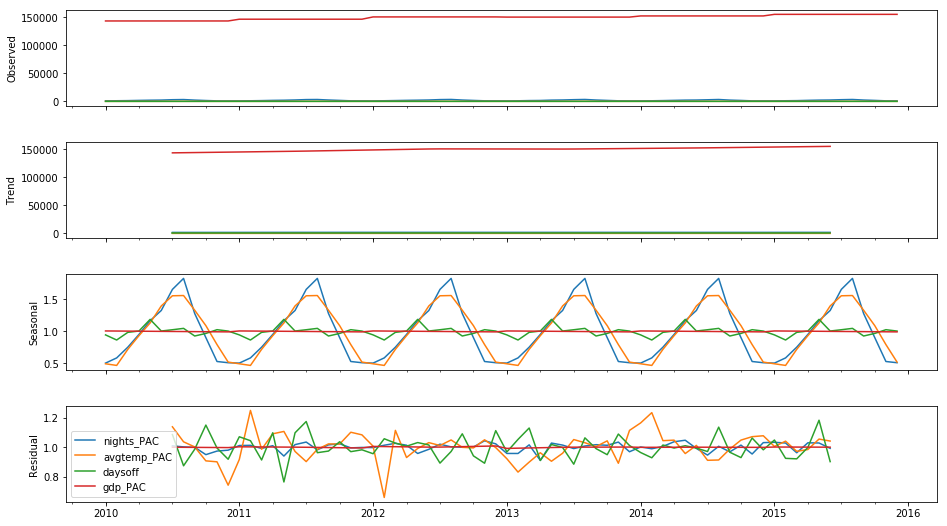

In [11]:
fig = plt.figure()  
fig = mult_data.plot()  
fig.set_size_inches(15, 8)
plt.legend()

### Forecasting the 3 parts: Seasonal, Trend, and Residuals

#### Seasonal forecasts for 2016 (nights only)
- Seasonal naive forecast method: Taking the same seasonal data as 2015

In [12]:
mult_seasonal.tail()

,nights_PAC,avgtemp_PAC,daysoff,gdp_PAC
2015-08-01,1.828675,1.560910,1.047527,0.998023
2015-09-01,1.279591,1.331053,0.928182,0.996701
2015-10-01,0.903177,1.090279,0.968439,0.995384
2015-11-01,0.529655,0.794319,1.027018,0.994073
2015-12-01,0.510644,0.520340,1.005456,0.992765


In [13]:
mult_seasonal_2016 = mult_seasonal[(mult_seasonal.index>='2015-01-01')&(mult_seasonal.index<'2016-01-01')]
mult_seasonal_2016

,nights_PAC,avgtemp_PAC,daysoff,gdp_PAC
2015-01-01,0.504709,0.494060,0.945701,1.007251
2015-02-01,0.585774,0.468400,0.865598,1.005924
2015-03-01,0.753537,0.719867,0.985516,1.004603
2015-04-01,0.952641,0.933739,1.005999,1.003286
2015-05-01,1.167660,1.132058,1.188224,1.001974
2015-06-01,1.327215,1.397917,1.006184,1.000667
2015-07-01,1.656722,1.557059,1.026155,0.999350
2015-08-01,1.828675,1.560910,1.047527,0.998023
2015-09-01,1.279591,1.331053,0.928182,0.996701
2015-10-01,0.903177,1.090279,0.968439,0.995384


#### Trend forecasts for 2016 (nights only)
- non-seasonal forecasting methods ex. ARIMA or Holt's

In [14]:
mult_trend.head()

,nights_PAC,avgtemp_PAC,daysoff,gdp_PAC
2010-07-01,1769.145833,14.666667,9.875000,143242.681530
2010-08-01,1765.466667,14.833333,9.833333,143502.892859
2010-09-01,1764.709167,15.000000,9.833333,143763.104187
2010-10-01,1767.228333,15.166667,9.875000,144023.315516
2010-11-01,1766.691667,15.375000,9.791667,144283.526845


In [15]:
from pyramid.arima import auto_arima
arima_trend = auto_arima(np.array(mult_trend.nights_PAC), start_p=0, start_q=0, max_p=20, max_q=20, m=12,
                    start_P=0, max_P=20, seasonal=False, d=1, D=1, trace=True,
                    error_action='ignore', suppress_warnings=True, stepwise=False, random=True, random_state=42) 

arima_trend.summary()


Fit ARIMA: order=(6, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(8, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=386.432, BIC=390.587, Fit time=0.004 seconds
Fit ARIMA: order=(5, 1, 0); AIC=333.072, BIC=347.615, Fit time=0.148 seconds
Fit ARIMA: order=(0, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(9, 1, 0); AIC=337.305, BIC=360.158, Fit time=0.765 seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1); AIC=327.398, BIC=335.708, Fit time=0.081 seconds
Fit ARIMA: order=(10, 1, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 0); AIC=338.841, BIC=349.229, Fit time=0.053 seconds
Total fit time: 1.097 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   59
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -159.699
Method:                       css-mle   S.D. of innovations              3.480
Date:                Tue, 04 Sep 2018   AIC                            327.398
Time:                        13:46:25   BIC                            335.708
Sample:                             1   HQIC                           330.642
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1898      1.382      0.861      0.393      -1.518       3.898
ar.L1.D.y      0.3554      0.121      2.943      0.005       0.119       0.592
ma.L1.D.y      0.9999      0.067     14.885      0.000       0.868       1.132
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.8134           +0.0000j            2.8134            0.0000
MA.1           -1.0001           +0.0000j            1.0001            0.5000
-----------------------------------------------------------------------------
"""

In [16]:
arima_trend.fit(mult_trend.nights_PAC)


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [17]:
arima_trend_forecast_2016 = arima_trend.predict(n_periods=12)
arima_trend_forecast_2016

array([1846.45339536, 1846.79214885, 1847.67944854, 1848.76172511,
       1849.91330485, 1851.08951792, 1852.27448673, 1853.4625677 ,
       1854.65175487, 1855.84133524, 1857.03105535, 1858.22082515])

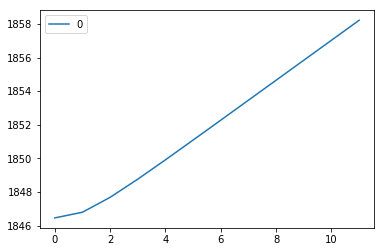

In [18]:
arima_trend_forecast_2016_df = pd.DataFrame(arima_trend_forecast_2016)
arima_trend_forecast_2016_df.plot()

#### Residual forecasts for 2016 (produces forecasts for all but we will use nights forecast only)
- VAR model
- Takes all variables into account and gives predictions for all
- We will be taking the VAR prediction for nights_PAC only

In [19]:
mult_residual.head()

,nights_PAC,avgtemp_PAC,daysoff,gdp_PAC
2010-07-01,1.008754,1.138510,1.085532,0.999742
2010-08-01,1.002161,1.036560,0.873729,0.999256
2010-09-01,0.999191,1.001714,0.986072,0.998770
2010-10-01,0.949383,0.907118,1.150226,0.998284
2010-11-01,0.973639,0.900706,0.994409,0.997799


In [41]:
from statsmodels.tsa.api import VAR, DynamicVAR

model = VAR(mult_residual, dates=mult_residual.index)

lagorder_results = model.select_order(12)
print(lagorder_results.summary())

#results = model.fit(maxlags=11, ic='aic')
print(results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -28.93      -28.78   2.718e-13      -28.87
1       -28.95      -28.17   2.678e-13      -28.66
2       -28.93      -27.53   2.769e-13      -28.40
3       -28.74      -26.71   3.503e-13      -27.97
4       -28.84      -26.19   3.379e-13      -27.84
5       -29.06      -25.79   3.079e-13      -27.82
6       -28.97      -25.07   4.143e-13      -27.49
7       -29.18      -24.66   4.561e-13      -27.47
8       -29.31      -24.16   6.501e-13      -27.36
9       -29.58      -23.81   1.064e-12      -27.40
10      -34.42      -28.02   3.176e-14      -32.00
11      -78.10      -71.08   6.186e-32      -75.44
12     -243.1*     -235.5* 6.389e-102*     -240.3*
--------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 04, Sep

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [21]:
lag_order = results.k_ar
print(lag_order)

mult_resid_forecast_2016 = results.forecast(mult_residual.values[-lag_order:], 12)
mult_resid_forecast_2016

11


array([[1.01779952, 0.99359299, 1.05942543, 1.00062402],
       [0.99694245, 1.08346393, 0.94286745, 0.99962199],
       [0.9954525 , 1.04726294, 0.94884353, 0.99882955],
       [0.97867523, 0.991415  , 1.1102652 , 0.99859344],
       [0.96637076, 0.92151182, 0.96162506, 1.00091983],
       [1.0112017 , 0.77738818, 0.93841724, 1.00118098],
       [1.03624578, 0.96127179, 1.04021945, 1.0042267 ],
       [1.00986491, 1.06565244, 1.08542012, 1.0010574 ],
       [0.9669747 , 1.03206409, 0.91446888, 1.00000298],
       [1.01510209, 1.02696452, 1.06435238, 1.00045568],
       [0.9730436 , 1.08405881, 0.83922206, 1.00259277],
       [1.01633206, 1.01413695, 1.01681212, 0.9994195 ]])

In [22]:
mult_resid_forecast_2016_df = pd.DataFrame(mult_resid_forecast_2016)
mult_resid_forecast_2016_df

,0,1,2,3
0,1.017800,0.993593,1.059425,1.000624
1,0.996942,1.083464,0.942867,0.999622
2,0.995452,1.047263,0.948844,0.998830
3,0.978675,0.991415,1.110265,0.998593
4,0.966371,0.921512,0.961625,1.000920
5,1.011202,0.777388,0.938417,1.001181
6,1.036246,0.961272,1.040219,1.004227
7,1.009865,1.065652,1.085420,1.001057
8,0.966975,1.032064,0.914469,1.000003
9,1.015102,1.026965,1.064352,1.000456


#### Putting the decomposed forecasts back together (multiplicative; nights only)

In [23]:
mult_seasonal_2016_array = mult_seasonal_2016.nights_PAC.values
mult_seasonal_2016_df = pd.DataFrame(mult_seasonal_2016_array)
mult_seasonal_2016_df.head(2)


,0
0,0.504709
1,0.585774


### 2016 Nights forecast

In [24]:
forecast_2016 = mult_seasonal_2016_df[0] * arima_trend_forecast_2016_df[0] * mult_resid_forecast_2016_df[0]
forecast_2016

0      948.508567
1     1078.495714
2     1385.964192
3     1723.648122
4     2087.428814
5     2484.313578
6     3179.931012
7     3422.816337
8     2294.820255
9     1701.466884
10     957.071921
11     964.387072
Name: 0, dtype: float64

#### Actual values for 2016

In [25]:
nights_PAC_2016 = data_PAC[(data_PAC.index>='2016-01-01')&(data_PAC.index<'2017-01-01')]
nights_PAC_2016 = np.array(nights_PAC_2016.nights_PAC)
nights_PAC_2016_df = pd.DataFrame(nights_PAC_2016)
nights_PAC_2016_df.head(2)

,0
0,956.28
1,1141.47


### Compare with real number of nights in 2016

#### AIC for 2016 forecast

In [26]:
results.aic

-41.817774481634586

#### MASE for 2016 forecast

#### Function to calculate seasonal MASE
- Doesn't work properly in this specific case as forecast includes only 12 months of data into the future

In [27]:
# Define seasonality as 12 (monthly data) in argument when ground truth data includes at least 24 months

def seasonal_MASE(truth, forecast, seasonality=1):    
    period = truth.shape[0] # T
    # print(period)
    forecast_errors = np.abs(truth - forecast)
    # print(forecast_errors)
    mean_absolute_forecast_error = np.sum(forecast_errors) / period
    # print(mean_absolute_forecast_error)

    naive_period = truth.shape[0] - seasonality # T - m
    # print(naive_period)
    # print(truth[seasonality:])
    # print(truth[:period - seasonality])
    naive_errors = np.abs(truth[seasonality:] - truth[:period - seasonality])
    mean_absolute_naive_error = np.sum(naive_errors) / naive_period
    
    return mean_absolute_forecast_error / mean_absolute_naive_error

#### MASE for 2016 forecast

$$
\text{MASE} = \dfrac{\text{MAE}(\text{our method})}{\text{MAE}(\text{seasonal naive})}
$$

- How good our predictions are compared to the simplest model possible (seasonal naive)
- MAE is compared between the two models (our model and seasonal naive model)
- A seasonal naive model repeats the same value from the last period
    - ex. Oct 2015 had 540 nights so seasonal naive thinks Oct 2016 will have 540 nights as well
    - At MASE = 1, it means the predictions are just as good as a seasonal naive model
    
Goal: We want to have an MASE much less than 1

**MASE for our 2016 forecast** tells us that the error of our model is 25% of the seasonal naive model's error
> This means *4 times less error* than the seasonal naive model's error

In [28]:
MASE_2016 = seasonal_MASE(nights_PAC_2016, forecast_2016)
print('MASE: %f' % MASE_2016)

MASE: 0.253320


#### RMSE and MAE for 2016 forecast
- RMSE: For a given month, our 2016 forecast is usually off by about 140 hotel nights (give or take)
    - RMSE is sensitive to large errors because the error of each wrong prediction is squared


- MAE: For a given month, out 2016 forecast is usually off by about 96 hotel nights (give or take)
    - MAE doesn't penalize large errors (unlike RMSE), it gives equal weight to all kinds of errors

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_2016 = np.sqrt(mean_squared_error(nights_PAC_2016, forecast_2016))
mae_2016 = mean_absolute_error(nights_PAC_2016, forecast_2016)
rmse_2016, mae_2016

(140.63400615444044, 96.91499230042568)

#### Predictions vs. Ground truth for Hotel nights PAC 2016

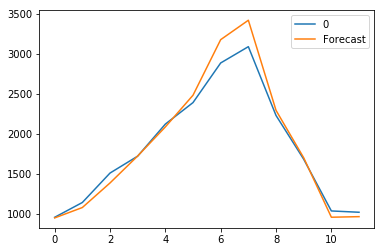

In [30]:
nights_PAC_2016_df.plot(label='Real')
forecast_2016.plot(label='Forecast')
plt.legend()

### Extra - 2017 forecast comparison

In [31]:
mult_resid_forecast_2017 = results.forecast(mult_residual.values[-lag_order:], 24)
mult_resid_forecast_2017_df = pd.DataFrame(mult_resid_forecast_2017)
mult_resid_forecast_2017_df.head()

,0,1,2,3
0,1.017800,0.993593,1.059425,1.000624
1,0.996942,1.083464,0.942867,0.999622
2,0.995452,1.047263,0.948844,0.998830
3,0.978675,0.991415,1.110265,0.998593
4,0.966371,0.921512,0.961625,1.000920


In [32]:
# Same seasonal values as 2015
mult_seasonal_2016_df.head()

,0
0,0.504709
1,0.585774
2,0.753537
3,0.952641
4,1.167660


In [33]:
arima_trend_forecast_2017 = arima_trend.predict(n_periods=24)
arima_trend_forecast_2017_df = pd.DataFrame(arima_trend_forecast_2017)
arima_trend_forecast_2017_df.head()

,0
0,1846.453395
1,1846.792149
2,1847.679449
3,1848.761725
4,1849.913305


In [34]:
nights_PAC_2017 = data_PAC[(data_PAC.index>='2017-01-01')&(data_PAC.index<'2017-12-02')]
nights_PAC_2017 = np.array(nights_PAC_2017.nights_PAC)
nights_PAC_2017_df = pd.DataFrame(nights_PAC_2017)
nights_PAC_2017_df.head()

,0
0,1000.33
1,1148.06
2,1409.69
3,2011.76
4,2092.09


In [35]:
nights_resid_2017 = mult_resid_forecast_2017_df[0][12:24]
forecast_2017 = mult_seasonal_2016_df[0].values * arima_trend_forecast_2017_df[12:24].values.transpose()[0] * nights_resid_2017.values.transpose()
forecast_2017_df = pd.Series(forecast_2017.transpose())
forecast_2017_df

0      951.379603
1     1081.717215
2     1418.559921
3     1809.919698
4     2132.830647
5     2410.678051
6     3071.551011
7     3347.361573
8     2505.290719
9     1702.957823
10     968.919986
11     970.173755
dtype: float64

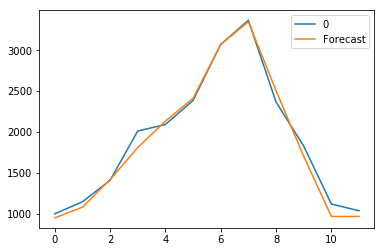

In [36]:
nights_PAC_2017_df.plot(label='Real')
forecast_2017_df.plot(label='Forecast')
plt.legend()

In [37]:
MASE_2017 = seasonal_MASE(nights_PAC_2017, forecast_2017)
print('MASE: %f' % MASE_2017)

MASE: 0.175012


In [39]:
rmse_2017 = np.sqrt(mean_squared_error(nights_PAC_2017, forecast_2017))
mae_2017 = mean_absolute_error(nights_PAC_2017, forecast_2017)
rmse_2017, mae_2017

(96.9801385746348, 74.65505795809094)

## Cross Validation for VAR Hyperparameters selection

In [94]:
mae_fold = []
mse_fold = []
rmse_fold = []
smase_fold= []
startyear = '2010-01-01'
startyear2 = '2012-01-01' # For error check
for index in range(2012,2018):
    ##Cutting Timeseries by year
    nextyear = str(index)+'-01-01'
    predictyear = str(index+1)+'-01-01'
    
    ##Time series Decomposition
    residualsbyyear = mult_residual[(mult_residual.index>=startyear)&(mult_residual.index<nextyear)] #dftrain
    trendbyyear = mult_trend[(mult_trend.index>=startyear)&(mult_trend.index<nextyear)]
    seasonalitybyyear = mult_seasonal[(mult_seasonal.index>=nextyear)&(mult_seasonal.index<predictyear)]
    
    train_nights  = np.array(data_PAC[(data_PAC.index>=startyear)&(data_PAC.index<nextyear)].nights_PAC)
    test_nights = np.array(data_PAC[(data_PAC.index>=nextyear)&(data_PAC.index<predictyear)].nights_PAC)
    #test_exogenous =  np.array(dftest[['avgtemp_PDL','gdp_PDL','daysoff']])
    #tc_fit = auto_arima(y=train_nights,exogenous=train_exogenous,start_p=1, start_q=1, max_p=3, max_q=3, m=12,
    #                start_P=1, seasonal=True, d=1, D=1, trace=True,
    #                error_action='ignore',  # don't want to know if an order does not work
    #                suppress_warnings=True,  # don't want convergence warnings
    #                stepwise=True)
    
    ##VAR Application for residuals
    model = VAR(residualsbyyear, dates=residualsbyyear.index)
    lagorder_results = model.select_order(3)
    print(lagorder_results.summary())
    results = model.fit(maxlags=3, ic='aic')## k to automatize
    print(results.summary())
    tc_future_forecast_resi = results.forecast(mult_residual.values[-lag_order:], 12)
    
    ##ARIMA Application for trend
    arima_trend = auto_arima(np.array(trendbyyear.nights_PAC), start_p=0, start_q=0, max_p=20, max_q=20, m=12,
                    start_P=0, max_P=20, seasonal=False, d=1, D=1, trace=True,
                    error_action='ignore', suppress_warnings=True, stepwise=False, random=True, random_state=42)
    arima_trend.fit(trendbyyear.nights_PAC)
    tc_future_forecast_trend = arima_trend.predict(n_periods=12)
    
    ##Seasonality
    tc_future_forecast_seas = seasonalitybyyear.nights_PAC
    
    ##Forecasting
    
    tc_future_forecast = tc_future_forecast_seas.values * tc_future_forecast_trend * tc_future_forecast_resi[:,0]
    
    mae_fold.append(mean_absolute_error(test_nights, tc_future_forecast))
    mse = mean_squared_error(test_nights, tc_future_forecast)
    mse_fold.append(mse)
    rmse_fold.append(sqrt(mse))
    smase_fold.append(seasonal_MASE(test_nights,tc_future_forecast))
    
    print('MAE:')
    print(mae_fold)    
    print('MSE:')
    print(mse_fold)
    print('RMSE:')
    print(rmse_fold)
    print('SMASE:')
    print(smase_fold)


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -28.23      -28.04   5.506e-13      -28.23
1      -28.38      -27.44   5.233e-13      -28.39
2      -32.52      -30.83   1.579e-14      -32.54
3     -104.1*     -101.6*  2.423e-44*     -104.1*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 04, Sep, 2018
Time:                     16:32:29
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -101.597
Nobs:                     15.0000    HQIC:                  -104.078
Log likelihood:           747.251    FPE:                2.42302e-44
AIC:                     -104.052    Det(Omega_mle):     4.31780e-46
--------------------------------------------------------------------
Results for

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(5, 1, 0); AIC=170.301, BIC=179.872, Fit time=0.143 seconds
Fit ARIMA: order=(0, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(9, 1, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1); AIC=167.966, BIC=173.435, Fit time=0.047 seconds
Fit ARIMA: order=(10, 1, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 0); AIC=173.961, BIC=180.798, Fit time=0.054 seconds
Total fit time: 0.283 seconds
MAE:
[71.26727076730593, 43.79131377022529]
MSE:
[9845.256858395902, 4154.401101056133]
RMSE:
[99.22326772685881, 64.45464375090543]
SMASE:
[0.158999358769844, 0.09647189913351895]
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -28.12     -27.95*   6.144e-13     -28.06*
1     -28.20*      -27.34  5.707e-13*      -27.89
2      -28.15      -26.62   6.139e-13  

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(8, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=266.343, BIC=269.770, Fit time=0.003 seconds
Fit ARIMA: order=(5, 1, 0); AIC=240.269, BIC=252.264, Fit time=0.134 seconds
Fit ARIMA: order=(0, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(9, 1, 0); AIC=239.524, BIC=258.373, Fit time=1.217 seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1); AIC=234.637, BIC=241.492, Fit time=0.105 seconds
Fit ARIMA: order=(10, 1, 0); AIC=241.149, BIC=261.711, Fit time=1.753 seconds
Fit ARIMA: order=(3, 1, 0); AIC=242.349, BIC=250.916, Fit time=0.071 seconds
Total fit time: 3.324 seconds
MAE:
[71.26727076730593, 43.79131377022529, 63.08153180582147]
MSE:
[9845.256858395902, 4154.401101056133, 8271.73742900736]
RMSE:
[99.22326772685881, 64.45464375090543, 90.94909251338004]
SMASE:
[0.158999358769844, 0.09647189913351895, 0.14281738882442915]
 VAR Order Selection (* highlights the minimums)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(6, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(8, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=348.920, BIC=352.861, Fit time=0.004 seconds
Fit ARIMA: order=(5, 1, 0); AIC=302.222, BIC=316.014, Fit time=0.160 seconds
Fit ARIMA: order=(0, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(9, 1, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1); AIC=295.978, BIC=303.860, Fit time=0.060 seconds
Fit ARIMA: order=(10, 1, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 0); AIC=307.083, BIC=316.935, Fit time=0.066 seconds
Total fit time: 0.339 seconds
MAE:
[71.26727076730593, 43.79131377022529, 63.08153180582147, 38.91196943663352]
MSE:
[9845.256858395902, 4154.401101056133, 8271.73742900736, 2326.7024473047954]
RMSE:
[99.22326772685881, 64.45464375090543, 90.94909251338004, 48.23590413068667]
SMASE:
[0.15

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(5, 1, 0); AIC=333.072, BIC=347.615, Fit time=0.183 seconds
Fit ARIMA: order=(0, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(9, 1, 0); AIC=337.305, BIC=360.158, Fit time=0.839 seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1); AIC=327.398, BIC=335.708, Fit time=0.099 seconds
Fit ARIMA: order=(10, 1, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 0); AIC=338.841, BIC=349.229, Fit time=0.057 seconds
Total fit time: 1.229 seconds


ValueError: operands could not be broadcast together with shapes (0,) (12,) 

In [80]:
tc_future_forecast_seas.values

array([0.50470856, 0.5857743 , 0.75353745, 0.95264057, 1.1676603 ,
       1.32721476, 1.65672176, 1.82867486, 1.27959103, 0.90317714,
       0.52965504, 0.51064423])

In [74]:
tc_future_forecast_trend

array([1869.76560126, 1872.0160591 , 1875.79695129, 1880.19928549,
       1884.85395991, 1889.61109859, 1894.40984348, 1899.22548284,
       1904.04798228, 1908.87326731, 1913.69968344, 1918.52655886])

In [75]:
tc_future_forecast_resi[:,0]

array([0.97340875, 0.98366651, 1.02173159, 1.00760566, 1.03965677,
       0.94446221, 1.01100003, 0.91964262, 0.94990841, 0.92780826,
       0.92397302, 0.93400903])